# First look

The goal of this Notebook is to load the datasets and have a first look at the correlation, to see if this seems at all reasonable.

In [1]:
INHABITANTS_GERMANY = 83.2E6 # https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/_inhalt.html

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
corona_data = pd.read_csv("../dat/CoronaData.csv", parse_dates=["date"])
weather_data = pd.read_csv("../dat/WeatherData.csv", parse_dates=["date"])

In [4]:
corona_data.head()

,Unnamed: 0,id_county,name_county,id_state,name_state,cases,deaths,date,cum_cases,cum_deaths
0,0,1001.0,SK Flensburg,1.0,Schleswig-Holstein,0.0,0.0,2020-01-02,0.0,0.0
1,1,1001.0,SK Flensburg,1.0,Schleswig-Holstein,0.0,0.0,2020-01-03,0.0,0.0
2,2,1001.0,SK Flensburg,1.0,Schleswig-Holstein,0.0,0.0,2020-01-04,0.0,0.0
3,3,1001.0,SK Flensburg,1.0,Schleswig-Holstein,0.0,0.0,2020-01-05,0.0,0.0
4,4,1001.0,SK Flensburg,1.0,Schleswig-Holstein,0.0,0.0,2020-01-06,0.0,0.0


In [5]:
weather_data.head()

,date,air temperature
0,2019-01-01 01:00:00,6.504000
1,2019-01-01 02:00:00,6.358333
2,2019-01-01 03:00:00,6.258333
3,2019-01-01 04:00:00,6.141667
4,2019-01-01 05:00:00,6.070833


## Simplify data

For this first experiment, we will simplify the data by reducing it to daily precision and germanywide data.

### Corona Data

In [6]:
corona_data_simple = corona_data.groupby("date").sum()[["cases", "deaths"]]
corona_data_simple

,cases,deaths
date,,
2020-01-02,1.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
2020-01-05,0.0,0.0
2020-01-06,0.0,0.0
...,...,...
2022-01-27,182524.0,10.0
2022-01-28,158981.0,11.0
2022-01-29,90840.0,3.0


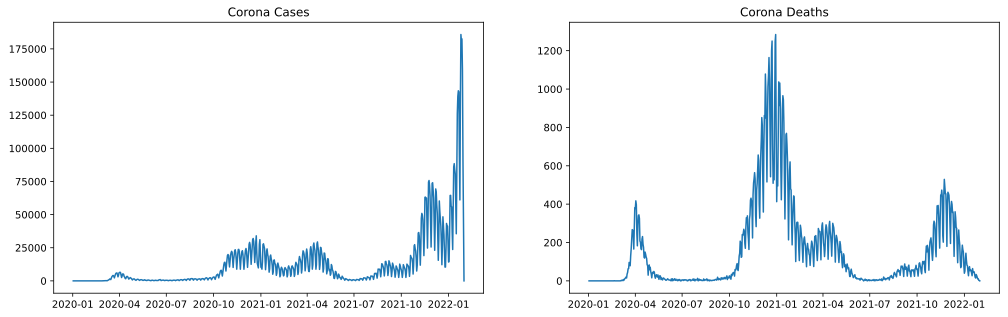

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

axs[0].plot(corona_data_simple.index, corona_data_simple["cases"])
axs[0].set_title("Corona Cases")

axs[1].plot(corona_data_simple.index, corona_data_simple["deaths"])
axs[1].set_title("Corona Deaths")

plt.show()

In order to be more useful, the data has to be smoothed over seven days

In [8]:
cases = corona_data_simple.cases.to_numpy()
cases_smoothed = np.convolve(cases, np.ones(7), mode="same")
deaths = corona_data_simple.deaths.to_numpy()
deaths_smoothed = np.convolve(deaths, np.ones(7), mode="same")

corona_data_simple["cases_smoothed"] = cases_smoothed / 7
corona_data_simple["deaths_smoothed"] = deaths_smoothed / 7

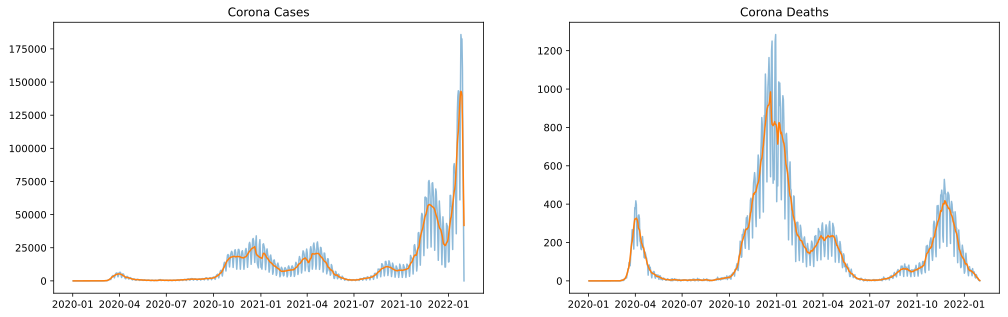

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

axs[0].plot(corona_data_simple.index, corona_data_simple["cases"], alpha=0.5)
axs[0].plot(corona_data_simple.index, corona_data_simple["cases_smoothed"])
axs[0].set_title("Corona Cases")

axs[1].plot(corona_data_simple.index, corona_data_simple["deaths"], alpha=0.5)
axs[1].plot(corona_data_simple.index, corona_data_simple["deaths_smoothed"])
axs[1].set_title("Corona Deaths")

plt.show()

Now we can calculate the case fatality rate. Since the values are not reliable in the beginning, we will set $cfr = 0$ if there have been few (e.g. 2) new cases that day (this should only occur before the first wave).

In [10]:
cases_smoothed_modified = corona_data_simple["cases_smoothed"].apply(lambda x: x if x > 2 else np.inf)
cfr = corona_data_simple["deaths_smoothed"] / cases_smoothed_modified

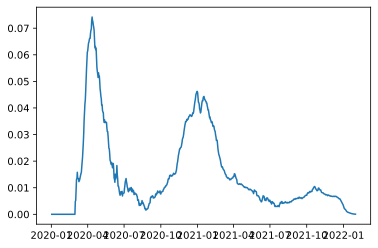

In [11]:
plt.plot(cfr)

In [12]:
corona_data_simple["cfr"] = cfr

In [13]:
corona = corona_data_simple

### Weather data

In [14]:
weather_data

,date,air temperature
0,2019-01-01 01:00:00,6.504000
1,2019-01-01 02:00:00,6.358333
2,2019-01-01 03:00:00,6.258333
3,2019-01-01 04:00:00,6.141667
4,2019-01-01 05:00:00,6.070833
...,...,...
27018,2022-01-30 19:00:00,3.028000
27019,2022-01-30 20:00:00,2.504000
27020,2022-01-30 21:00:00,2.352000
27021,2022-01-30 22:00:00,2.096000


In [15]:
weather = weather_data.set_index("date").resample("D").asfreq().bfill()

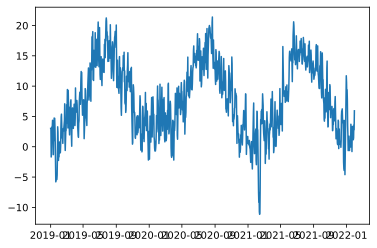

In [16]:
plt.plot(weather["air temperature"])
plt.show()

## First looks at the data

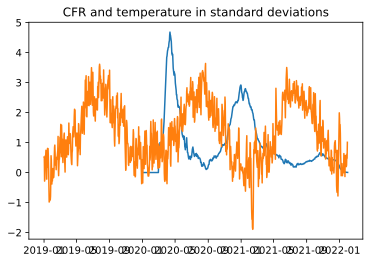

In [17]:
plt.plot(corona.cfr / corona.cfr.std())
plt.plot(weather["air temperature"] / weather["air temperature"].std())
plt.title("CFR and temperature in standard deviations")
plt.show()

Here one can see, that there seems to be a correlation between temperature and CFR. Also the CFR decreases, over time, so that also plays a role. The red 

## Basic machine learning

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
linear_model = LinearRegression()

In [20]:
temperature = weather["air temperature"].to_numpy()
time = np.arange(temperature.shape[0])

X = np.stack((temperature, time), axis=1)
y = corona.cfr.to_numpy()

In [21]:
linear_model.fit(X, y)

ValueError: Found input variables with inconsistent numbers of samples: [1126, 761]

In [ ]:
plt.plot(corona.cfr)
plt.plot(corona.index, linear_model.predict(X))

We can see, that there is already some correlation. However the assumption, that we have an underlying linear drop from the beginning, does not hold, if we start training before the first wave. So let us change that.

In [ ]:
linear_model = LinearRegression()

y = corona.cfr.to_numpy()

temperature = weather["air temperature"].to_numpy()
time = np.arange(temperature.shape[0])

peak_of_first_wave = np.argmax(y) # this only works, because the peak of the first wave is the highest peak at all

X = np.stack((temperature, time), axis=1)

linear_model.fit(X[peak_of_first_wave:], y[peak_of_first_wave:])

plt.plot(corona.cfr)
plt.plot(corona.index, linear_model.predict(X))

Already now we have a much better model, and the error we make in return is only on the part, where there was no real Corona in Germany yet.

We can also try a transformation on the temperature:

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
plt.plot(weather["air temperature"])
plt.plot(((weather["air temperature"] - 20) / 5).apply(sigmoid) * 30)

In [ ]:
linear_model = LinearRegression()

y = corona.cfr.to_numpy()

temperature = weather["air temperature"].to_numpy()
time = np.arange(temperature.shape[0])

peak_of_first_wave = np.argmax(y) # this only works, because the peak of the first wave is the highest peak at all

X = np.stack((sigmoid((temperature - 5) / 10), time), axis=1)

linear_model.fit(X[peak_of_first_wave:], y[peak_of_first_wave:])

plt.plot(corona.cfr)
plt.plot(corona.index, linear_model.predict(X))